In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

In [52]:
# Download the data of Davidson
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df = pd.read_csv(url,index_col=0,parse_dates=[0],encoding='ISO-8859-1')

The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [53]:
np.random.seed(42)
df.head(5)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [93]:
df["hate_speech"].value_counts()

0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: hate_speech, dtype: int64

In [55]:
df["class"].value_counts() 
#1430 tweets considered as hateful content

1    19190
2     4163
0     1430
Name: class, dtype: int64

NameError: name 'save_fig' is not defined

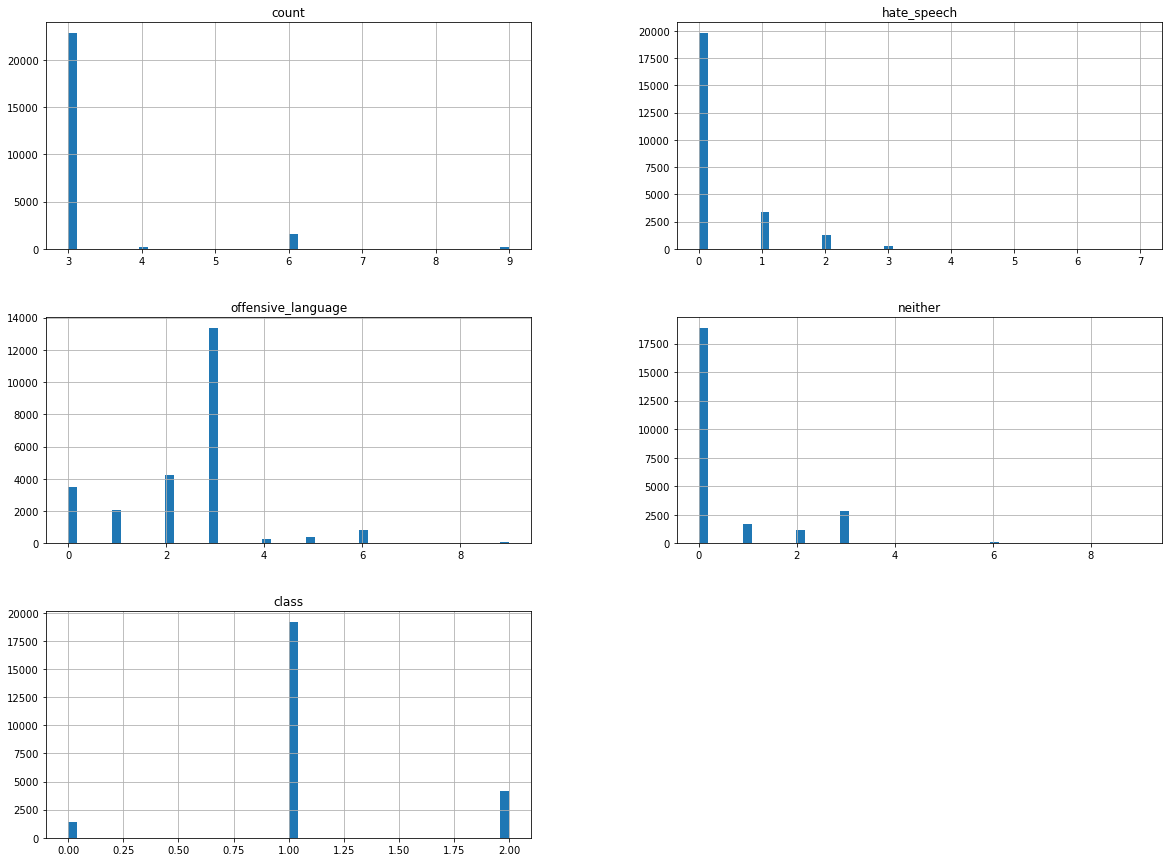

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [57]:
#No missing values
sample_incomplete_rows = df[df.isnull().any(axis=1)].head()
sample_incomplete_rows

,count,hate_speech,offensive_language,neither,class,tweet


In [58]:
df.drop(columns=['count','hate_speech','offensive_language','neither'])

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...
...,...,...
25291,1,you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8...
25292,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy"
25294,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again
25295,1,youu got wild bitches tellin you lies


# Cleaning the tweets

In [8]:
conda install -c conda-forge wordcloud=1.6.0 

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\ASUS\anaconda3
Note: you may need to restart the kernel to use updated packages.


  added / updated specs:
    - wordcloud=1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py38haa244fe_0         3.1 MB  conda-forge
    openssl-1.1.1h             |       he774522_0         5.8 MB  conda-forge
    python_abi-3.8             |           1_cp38           4 KB  conda-forge
    wordcloud-1.6.0            |   py38hfa6e2cd_0         189 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.0 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/win-64::

(-0.5, 399.5, 199.5, -0.5)

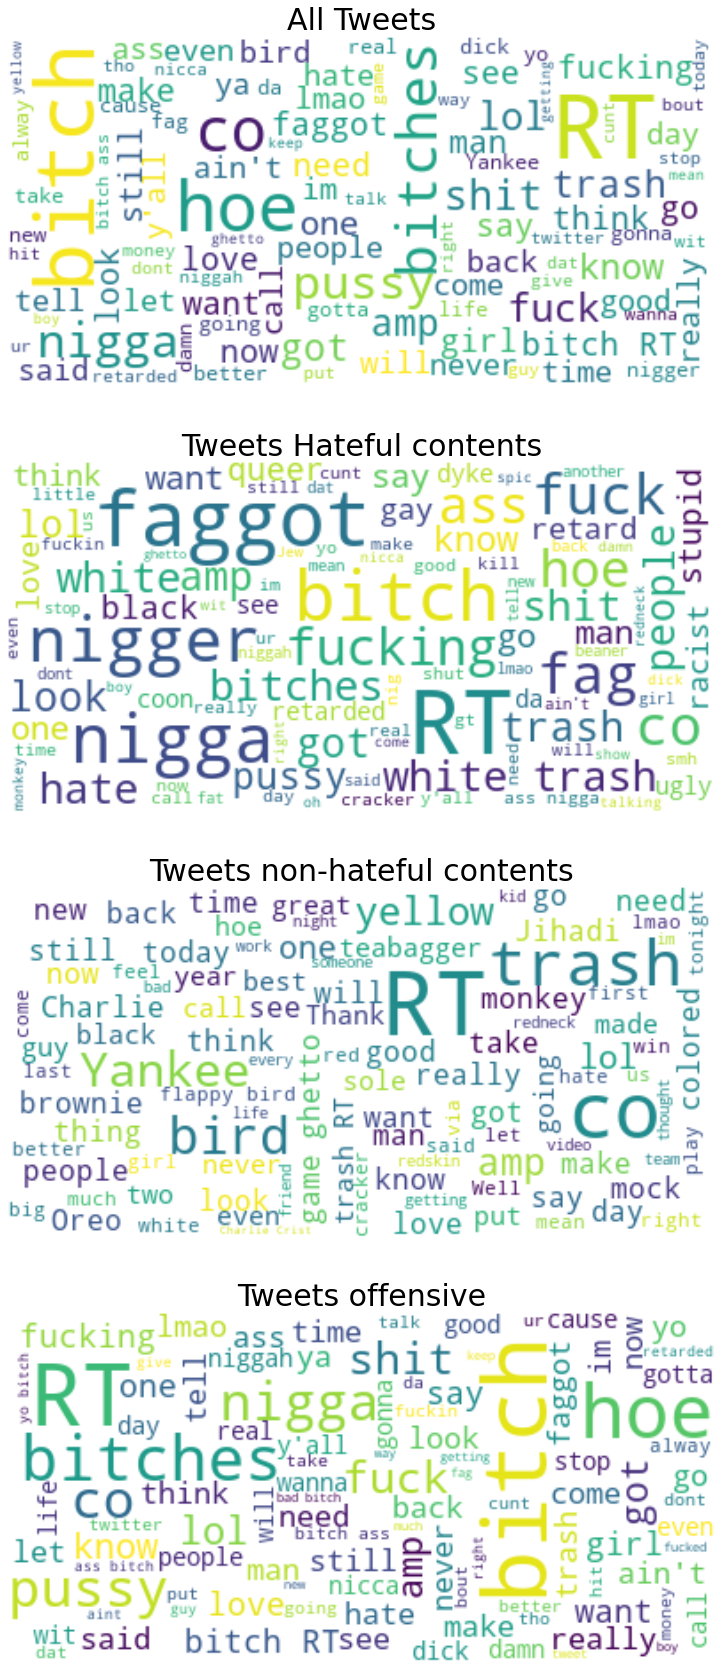

In [60]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

# Start with one review:
df_hateful = df[df['class']==0]
df_nonhateful = df[df['class']==2]
df_offensive = df[df['class']==1]
tweet_All = " ".join(review for review in df.tweet)
tweet_hateful = " ".join(review for review in df_hateful.tweet)
tweet_nonhateful = " ".join(review for review in df_nonhateful.tweet)
tweet_offensive = " ".join(review for review in df_offensive.tweet)

fig, ax = plt.subplots(4, 1, figsize  = (30,30))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
wordcloud_hateful = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_hateful)
wordcloud_nonhateful = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_nonhateful)
wordcloud_offensive = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_offensive)

# Display the generated image:
ax[0].imshow(wordcloud_ALL, interpolation='bilinear')
ax[0].set_title('All Tweets', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_hateful, interpolation='bilinear')
ax[1].set_title('Tweets Hateful contents',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_nonhateful, interpolation='bilinear')
ax[2].set_title('Tweets non-hateful contents',fontsize=30)
ax[2].axis('off')
ax[3].imshow(wordcloud_offensive, interpolation='bilinear')
ax[3].set_title('Tweets offensive',fontsize=30)
ax[3].axis('off')

In [ ]:
# Remove punctuation

In [9]:
string.punctuation


conda-4.9.2          | 3.1 MB    | #########1 |  92% 
conda-4.9.2          | 3.1 MB    | #########5 |  96% 
conda-4.9.2          | 3.1 MB    | ########## | 100% 
conda-4.9.2          | 3.1 MB    | ########## | 100% 

wordcloud-1.6.0      | 189 KB    |            |   0% 
wordcloud-1.6.0      | 189 KB    | 8          |   8% 
wordcloud-1.6.0      | 189 KB    | ####2      |  42% 
wordcloud-1.6.0      | 189 KB    | #####      |  51% 
wordcloud-1.6.0      | 189 KB    | #####9     |  59% 
wordcloud-1.6.0      | 189 KB    | ########4  |  85% 
wordcloud-1.6.0      | 189 KB    | ########## | 100% 
wordcloud-1.6.0      | 189 KB    | ########## | 100% 

python_abi-3.8       | 4 KB      |            |   0% 
python_abi-3.8       | 4 KB      | ########## | 100% 
python_abi-3.8       | 4 KB      | ########## | 100% 

openssl-1.1.1h       | 5.8 MB    |            |   0% 
openssl-1.1.1h       | 5.8 MB    |            |   0% 
openssl-1.1.1h       | 5.8 MB    | 1          |   2% 
openssl-1.1.1h       | 5

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def remove_punct(text):
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(mention_regex, '',text)
    text = re.sub(giant_url_regex, '',text)
    return text

df['tweets_punct'] = df['tweet'].apply(lambda x: remove_punct(x))
df.head(10)

,count,hate_speech,offensive_language,neither,class,tweet,tweets_punct
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...,RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you ...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,RT mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...,RT UrKindOfBrand Dawg RT sbabylife You ever fuck a bitch and she start to cry You be confused a...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,RT CGAnderson vivabased she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...,RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch ...
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for some...",TMadisonx The shit just blows meclaim you so faithful and down for somebody but still fucking wi...
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit g...",BrighterDays I can not just sit up and HATE on another bitch I got too much shit going on
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;,selfiequeenbri cause Im tired of you big bitches coming for us skinny girls
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; thats that """,amp you might not get ya bitch back amp thats that
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Mariam""\n\nbitch",rhythmixx hobbies include fighting Mariam\n\nbitch


# Tokenization

Split the words in the Tweets so we used the tokenizer available in the nltk library

In [17]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['Tweet_tokenized'] = df['tweets_punct'].apply(lambda x: tokenization(x.lower()))
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweets_punct,Tweet_tokenized
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...,RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you ...,"[, rt, mayasolovely, as, a, woman, you, shouldnt, complain, about, cleaning, up, your, house, am..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,RT mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place,"[, rt, mleew, boy, dats, coldtyga, dwn, bad, for, cuffin, dat, hoe, in, the, st, place]"
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...,RT UrKindOfBrand Dawg RT sbabylife You ever fuck a bitch and she start to cry You be confused a...,"[, rt, urkindofbrand, dawg, rt, sbabylife, you, ever, fuck, a, bitch, and, she, start, to, cry, ..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,RT CGAnderson vivabased she look like a tranny,"[, rt, cganderson, vivabased, she, look, like, a, tranny]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...,RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch ...,"[, rt, shenikaroberts, the, shit, you, hear, about, me, might, be, true, or, it, might, be, fake..."


# Remove stopwords

In [19]:
import nltk
nltk.download('stopwords')

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,count,hate_speech,offensive_language,neither,class,tweet,tweets_punct,Tweet_tokenized,Tweet_nonstop
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...,RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you ...,"[, rt, mayasolovely, as, a, woman, you, shouldnt, complain, about, cleaning, up, your, house, am...","[, rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]"
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,RT mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place,"[, rt, mleew, boy, dats, coldtyga, dwn, bad, for, cuffin, dat, hoe, in, the, st, place]","[, rt, mleew, boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]"
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...,RT UrKindOfBrand Dawg RT sbabylife You ever fuck a bitch and she start to cry You be confused a...,"[, rt, urkindofbrand, dawg, rt, sbabylife, you, ever, fuck, a, bitch, and, she, start, to, cry, ...","[, rt, urkindofbrand, dawg, rt, sbabylife, ever, fuck, bitch, start, cry, confused, shit]"
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,RT CGAnderson vivabased she look like a tranny,"[, rt, cganderson, vivabased, she, look, like, a, tranny]","[, rt, cganderson, vivabased, look, like, tranny]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...,RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch ...,"[, rt, shenikaroberts, the, shit, you, hear, about, me, might, be, true, or, it, might, be, fake...","[, rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, ]"
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for some...",TMadisonx The shit just blows meclaim you so faithful and down for somebody but still fucking wi...,"[tmadisonx, the, shit, just, blows, meclaim, you, so, faithful, and, down, for, somebody, but, s...","[tmadisonx, shit, blows, meclaim, faithful, somebody, still, fucking, hoes, ]"
6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit g...",BrighterDays I can not just sit up and HATE on another bitch I got too much shit going on,"[brighterdays, i, can, not, just, sit, up, and, hate, on, another, bitch, i, got, too, much, shi...","[brighterdays, sit, hate, another, bitch, got, much, shit, going]"
7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;,selfiequeenbri cause Im tired of you big bitches coming for us skinny girls,"[selfiequeenbri, cause, im, tired, of, you, big, bitches, coming, for, us, skinny, girls]","[selfiequeenbri, cause, im, tired, big, bitches, coming, us, skinny, girls]"
8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; thats that """,amp you might not get ya bitch back amp thats that,"[, amp, you, might, not, get, ya, bitch, back, amp, thats, that, ]","[, amp, might, get, ya, bitch, back, amp, thats, ]"
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Mariam""\n\nbitch",rhythmixx hobbies include fighting Mariam\n\nbitch,"[, rhythmixx, hobbies, include, fighting, mariam, bitch]","[, rhythmixx, hobbies, include, fighting, mariam, bitch]"


Stemming: bag-of-word model, the words that appear more frequently are used as the features for the classifier

In [24]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text

df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweets_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...,RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you ...,"[, rt, mayasolovely, as, a, woman, you, shouldnt, complain, about, cleaning, up, your, house, am...","[, rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]","[, rt, mayasolov, woman, shouldnt, complain, clean, hous, amp, man, alway, take, trash]"
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,RT mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place,"[, rt, mleew, boy, dats, coldtyga, dwn, bad, for, cuffin, dat, hoe, in, the, st, place]","[, rt, mleew, boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]","[, rt, mleew, boy, dat, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]"
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...,RT UrKindOfBrand Dawg RT sbabylife You ever fuck a bitch and she start to cry You be confused a...,"[, rt, urkindofbrand, dawg, rt, sbabylife, you, ever, fuck, a, bitch, and, she, start, to, cry, ...","[, rt, urkindofbrand, dawg, rt, sbabylife, ever, fuck, bitch, start, cry, confused, shit]","[, rt, urkindofbrand, dawg, rt, sbabylif, ever, fuck, bitch, start, cri, confus, shit]"
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,RT CGAnderson vivabased she look like a tranny,"[, rt, cganderson, vivabased, she, look, like, a, tranny]","[, rt, cganderson, vivabased, look, like, tranny]","[, rt, cganderson, vivabas, look, like, tranni]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...,RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch ...,"[, rt, shenikaroberts, the, shit, you, hear, about, me, might, be, true, or, it, might, be, fake...","[, rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, ]","[, rt, shenikarobert, shit, hear, might, true, might, faker, bitch, told, ya, ]"


In [26]:
import nltk
nltk.download('wordnet')

wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['Tweet_lemmatized'] = df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


,count,hate_speech,offensive_language,neither,class,tweet,tweets_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a...,RT mayasolovely As a woman you shouldnt complain about cleaning up your house amp as a man you ...,"[, rt, mayasolovely, as, a, woman, you, shouldnt, complain, about, cleaning, up, your, house, am...","[, rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]","[, rt, mayasolov, woman, shouldnt, complain, clean, hous, amp, man, alway, take, trash]","[, rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]"
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,RT mleew boy dats coldtyga dwn bad for cuffin dat hoe in the st place,"[, rt, mleew, boy, dats, coldtyga, dwn, bad, for, cuffin, dat, hoe, in, the, st, place]","[, rt, mleew, boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]","[, rt, mleew, boy, dat, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]","[, rt, mleew, boy, dat, coldtyga, dwn, bad, cuffin, dat, hoe, st, place]"
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry?...,RT UrKindOfBrand Dawg RT sbabylife You ever fuck a bitch and she start to cry You be confused a...,"[, rt, urkindofbrand, dawg, rt, sbabylife, you, ever, fuck, a, bitch, and, she, start, to, cry, ...","[, rt, urkindofbrand, dawg, rt, sbabylife, ever, fuck, bitch, start, cry, confused, shit]","[, rt, urkindofbrand, dawg, rt, sbabylif, ever, fuck, bitch, start, cri, confus, shit]","[, rt, urkindofbrand, dawg, rt, sbabylife, ever, fuck, bitch, start, cry, confused, shit]"
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,RT CGAnderson vivabased she look like a tranny,"[, rt, cganderson, vivabased, she, look, like, a, tranny]","[, rt, cganderson, vivabased, look, like, tranny]","[, rt, cganderson, vivabas, look, like, tranni]","[, rt, cganderson, vivabased, look, like, tranny]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker ...,RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch ...,"[, rt, shenikaroberts, the, shit, you, hear, about, me, might, be, true, or, it, might, be, fake...","[, rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, ]","[, rt, shenikarobert, shit, hear, might, true, might, faker, bitch, told, ya, ]","[, rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, ]"


Creation of a text with list of words in the tokenized_df1

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
countVectorizer = CountVectorizer()
countVector = countVectorizer.fit_transform(df['tweet'])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

24783 Number of tweets has 35852 words


# Bag-of-word approach

In [39]:
X = countVectorizer.fit_transform(df).toarray()

# Split the datasets

In [47]:
y = df.iloc[:, 0]

AttributeError: 'builtin_function_or_method' object has no attribute 'shape'

In [48]:
X.shape
X = X.transpose

AttributeError: 'builtin_function_or_method' object has no attribute 'shape'

In [49]:
y.shape
y = y.transpose

In [50]:
#How to split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

TypeError: Singleton array array(<built-in method transpose of numpy.ndarray object at 0x0000024E303F1CB0>,
      dtype=object) cannot be considered a valid collection.

In [ ]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predict Class
y_pred = classifier.predict(X_test)

# Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [56]:
test_set.head()

,count,hate_speech,offensive_language,neither,class,tweet
2326,3,0,3,0,1,934 8616\ni got a missed call from yo bitch
16283,3,0,3,0,1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...
19362,3,0,1,2,1,RT @eanahS__: @1inkkofrosess lol my credit ain...
16780,3,0,3,0,1,RT @Maxin_Betha Wipe the cum out of them faggo...
13654,3,1,2,0,1,Niggas cheat on they bitch and don't expect no...


In [103]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_set)
X_train_counts.shape

(6, 6)

In [104]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(6, 6)

https://towardsdatascience.com/multiclass-classification-with-word-bags-and-word-sequences-4fffd4d62e0c